# Final Project

Info 4609

Michael Murdock

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from skimage.transform import resize

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Init Plugin
Init Graph Optimizer
Init Kernel


#### Check Working Dir

In [2]:
os.getcwd()

'/Users/michaelm/Dropbox/INFO4604/Final Project'

#### Colab Data Import Steps (Kaggle)


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d brsdincer/vehicle-detection-image-set
! unzip vehicle-detection-image-set.zip

## Load and Label Data

In [2]:
labs, rel_paths, clabs = np.array([]), [], ''

for data in os.walk('data'):
    if data[0] != 'data':
        clabs = data[0].split('/')[1]
    for file_ in data[2]:
        labs = np.append(labs, np.where(clabs=='vehicles', 1, 0)).astype(int)
        rel_paths.append(f'{data[0]}/{file_}')

df_shuffled = pd.DataFrame(
    {'paths':rel_paths, 'labels':labs}).sample(
        frac=1, random_state=123).reset_index()

df_shuffled.head()

,index,paths,labels
0,10079,data/vehicles/366.png,1
1,5914,data/non-vehicles/extra5005.png,0
2,10361,data/vehicles/right (219).png,1
3,15977,data/vehicles/43.png,1
4,5379,data/non-vehicles/extra3465.png,0


## Read Images without Resizing

In [3]:
labels = df_shuffled['labels']
images = np.array([cv2.imread(p) for p in df_shuffled['paths']])
print(f'Images: \nshape - {images.shape}, size - {images.size}')

Images: 
 shape:(17760, 64, 64, 3), size:218234880


## Read and Resize Images For Comparison

In [ ]:
resized_images = np.array([cv2.resize(cv2.imread(p), (64, 64)) for p in df_shuffled['paths']])
# resize = np.array([resize(plt.imread(p), (32,32,3)) for p in df_shuffled['paths']])

#### Inspect Image Before and After Resizing

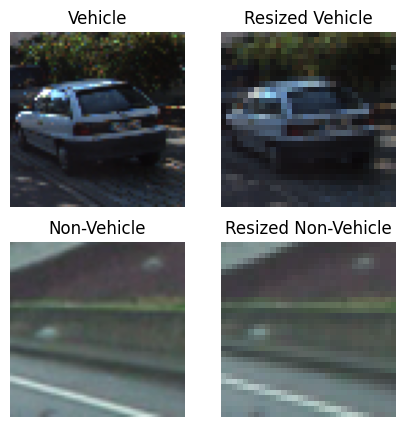

In [4]:
def label(df, r):
    return np.where(df['labels'][r]==1, 'Vehicle', 'Non-Vehicle')
# print label
def read_resize_plot(df, r, r2):
    # set fig
    f,(ax,ax1) = plt.subplots(2,2, figsize=(5,5))

    rlab, rlab2 = label(df, r), label(df, r2)

    ax[0].imshow(plt.imread(df['paths'][r]))
    ax[1].imshow(np.array(resize(plt.imread(df['paths'][r]), (32, 32, 3))))
    ax[0].set_title(rlab), ax[1].set_title(f'Resized {rlab}')
    ax[0].set_axis_off(), ax[1].set_axis_off()

    ax1[0].imshow(plt.imread(df['paths'][r2]))
    ax1[1].imshow(np.array(resize(plt.imread(df['paths'][r2]), (32, 32, 3))))
    ax1[0].set_title(rlab2), ax1[1].set_title(f'Resized {rlab2}')
    ax1[0].set_axis_off(), ax1[1].set_axis_off()

read_resize_plot(df_shuffled, 15, 25)

## Split Data and Inspect

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.25)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

#### Reshape From 4d to 2d

In [7]:
# reshaping for compatability with decision tree
nsamples, nx, ny, nz = X_train.shape
d2_Xtrain = X_train.reshape((nsamples,nx*ny*nz))

nsamples_, nx_, ny_, nz_ = X_test.shape
d2_Xtest = X_test.reshape((nsamples_,nx_*ny_*nz_))

d2_Xtrain.shape, d2_Xtest.shape

((13320, 12288), (4440, 12288))

## Instantiate and Train Decision Tree

In [8]:
max_depths = [3, 8, 14, 100]
min_leafs = [1, 5, 10, 15, 50]


training = []
testing = []
depths = []
leafs = []


for m in max_depths:
    for j in min_leafs:

        model = DecisionTreeClassifier(
            criterion='gini', max_depth=m, min_samples_leaf=j, random_state=123)
        model.fit(d2_Xtrain, y_train)

        test_predictions = model.predict(d2_Xtest)
        train_predictions = model.predict(d2_Xtrain)

        training.append(accuracy_score(train_predictions, y_train))
        testing.append(accuracy_score(test_predictions, y_test))
        depths.append(m)
        leafs.append(j)

df_ = pd.DataFrame({'train_acc': training, 'test_acc': testing,
                    'max_depth': depths, 'min_samples': leafs})

In [11]:
display(df_)

df_.loc[df_.test_acc.idxmax()]

,train_acc,test_acc,max_depth,min_samples
0,0.845721,0.837613,3,1
1,0.845721,0.837613,3,5
2,0.845721,0.837613,3,10
3,0.845721,0.837613,3,15
4,0.845721,0.837613,3,50
5,0.957132,0.911036,8,1
6,0.953303,0.911036,8,5
7,0.949024,0.905405,8,10
8,0.945420,0.903604,8,15
9,0.922147,0.895045,8,50


train_acc       0.980556
test_acc        0.914640
max_depth      14.000000
min_samples     5.000000
Name: 11, dtype: float64

## Plot Accuracies and Best Performing Tree

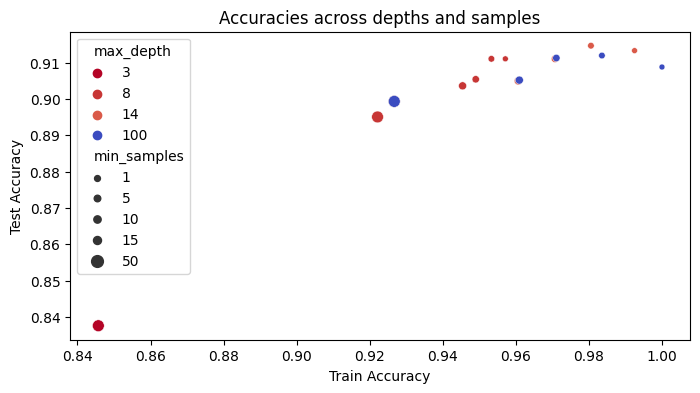

In [13]:
import seaborn as sb

f, ax = plt.subplots(figsize=(8,4))

sb.scatterplot(data = df_, x='train_acc', y='test_acc',
               hue='max_depth', size='min_samples', palette='coolwarm_r')

plt.title('Accuracies across depths and samples')
plt.xlabel('Train Accuracy')
plt.ylabel('Test Accuracy');

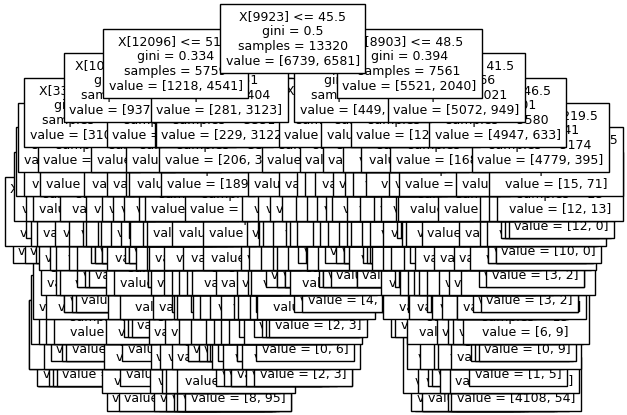

In [15]:
plt.figure()

best_model = DecisionTreeClassifier(
            criterion='gini', max_depth=14, min_samples_leaf=5, random_state=123).fit(d2_Xtrain, y_train)

tree.plot_tree(best_model, fontsize=9)

plt.show()

## Instantiate and Train Random Forest

In [16]:
print(df_.loc[df_['test_acc'].idxmax()])

estimators = [10, 50, 100, 300]

training = []
testing = []
n_est = []

for e in estimators:

    forest_model = RandomForestClassifier(
        n_estimators=e, max_depth=14, min_samples_leaf=5, random_state=123)
    forest_model.fit(d2_Xtrain, y_train)

    test_predictions = forest_model.predict(d2_Xtest)
    train_predictions = forest_model.predict(d2_Xtrain)

    training.append(accuracy_score(train_predictions, y_train))
    testing.append(accuracy_score(test_predictions, y_test))
    n_est.append(e)

forest_df = pd.DataFrame(
    {'train_acc': training, 'test_acc': testing, 'n_estimator': n_est})


train_acc       0.980556
test_acc        0.914640
max_depth      14.000000
min_samples     5.000000
Name: 11, dtype: float64


In [18]:
display(forest_df)

forest_df.loc[forest_df.test_acc.idxmax()]

,train_acc,test_acc,n_estimator
0,0.985360,0.951577,10
1,0.989565,0.959234,50
2,0.990390,0.959459,100
3,0.990991,0.961036,300


train_acc        0.990991
test_acc         0.961036
n_estimator    300.000000
Name: 3, dtype: float64

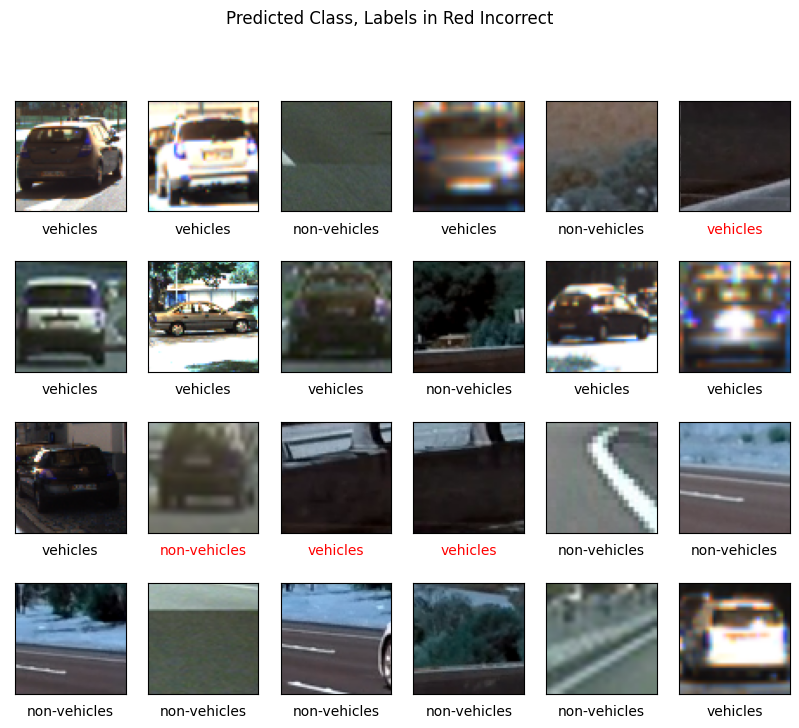

In [60]:
label_dict = {1.:'vehicles', 0.:'non-vehicles'}
y_fit = forest_model.predict(d2_Xtest)

def plot_predictions(xtest, ytest, yfit, samplesr, samplesc):
    fig, ax = plt.subplots(samplesr, samplesc, figsize=(10,8))
    pred_sub = np.array(ytest)
    for i, axi in enumerate(ax.flat):
        axi.imshow(xtest[i], cmap='bone')
        axi.set(xticks=[], yticks=[])
        axi.set_xlabel(label_dict[yfit[i]],
                    color='black' if yfit[i] == pred_sub[i] else 'red')
    fig.suptitle('Predicted Class, Labels in Red Incorrect', size=12);

plot_predictions(X_test, y_test, y_fit, 4, 6)

In [21]:
def process_iphone_photo(png):

    '''
    Resize, plot, and reshape Iphone images for compatability with decision tree model

    '''

    # set axis 
    f, ax = plt.subplots(1, 2, figsize=(10,6))

    # resize
    car_image = cv2.resize(cv2.imread(png), (64, 64))

    # plot image before and after resizing
    ax[0].imshow(cv2.imread(png))
    ax[1].imshow(car_image)

    # reshape
    nx, ny, nz = car_image.shape
    shaped_image = car_image.reshape(1, nx*ny*nz)

    return shaped_image
    

Predicted: Vehicle


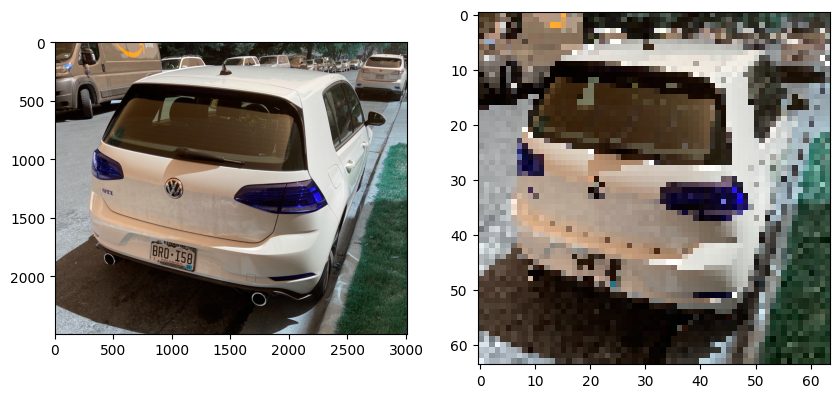

In [22]:
my_car = process_iphone_photo('my_car.png')

print('Predicted:', np.where(model.predict(my_car), 'Vehicle', 'Non-Vehicle')[0])

## Tensorflow Implentation

### Load and Preprocess Data

In [129]:
gen = ImageDataGenerator(rescale=1/255)

t_gen = gen.flow_from_directory(
    'data',
    target_size=(64,64),
    batch_size= 256,
    shuffle=True,
    class_mode='binary'
)

Found 17760 images belonging to 2 classes.


### Build Sequential Model

In [82]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(64, 64, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

# model.build(input_shape=(64,64,3))
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                7872576   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 7,875,585
Trainable params: 7,875,585
Non-trainable params: 0
_________________________________________________________________


### Load and Preprocess Dir

In [133]:
t_gen = ImageDataGenerator(rescale=1/255).flow_from_directory(
    'data',
    target_size=(64,64),
    batch_size= 256,
    shuffle=True,
    class_mode='binary'
)

Found 17760 images belonging to 2 classes.


In [83]:
# compiling model with adam optimizer and binary crossentropy loss function
keras_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.compile(
#     loss='binary_crossentropy', 
#     optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
#     metrics=['accuracy'])

# fitting train_generator to model

keras_model.fit(X_train, y_train, epochs=10, steps_per_epoch=np.ceil(17246/256), verbose=1)

Epoch 1/10


2022-11-06 01:41:53.195470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - 5s 62ms/step - loss: 51.2788 - accuracy: 0.8248
Epoch 2/10
68/68 [==============================] - 4s 59ms/step - loss: 0.5491 - accuracy: 0.9534
Epoch 3/10
68/68 [==============================] - 4s 59ms/step - loss: 0.1781 - accuracy: 0.9747
Epoch 4/10
68/68 [==============================] - 4s 63ms/step - loss: 0.8103 - accuracy: 0.9447
Epoch 5/10
68/68 [==============================] - 4s 60ms/step - loss: 0.2527 - accuracy: 0.9749
Epoch 6/10
68/68 [==============================] - 4s 59ms/step - loss: 0.0883 - accuracy: 0.9896
Epoch 7/10
68/68 [==============================] - 4s 58ms/step - loss: 0.0405 - accuracy: 0.9929
Epoch 8/10
68/68 [==============================] - 4s 65ms/step - loss: 0.0332 - accuracy: 0.9937
Epoch 9/10
68/68 [==============================] - 5s 68ms/step - loss: 0.0338 - accuracy: 0.9929
Epoch 10/10
68/68 [==============================] - 4s 60ms/step - loss: 0.0552 - accuracy: 0.9905


In [84]:
keras_model.predict(cv2.resize(cv2.imread('my_car.png'), (64,64)).reshape(1,64,64,3))

2022-11-06 01:43:15.578981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[1.]], dtype=float32)

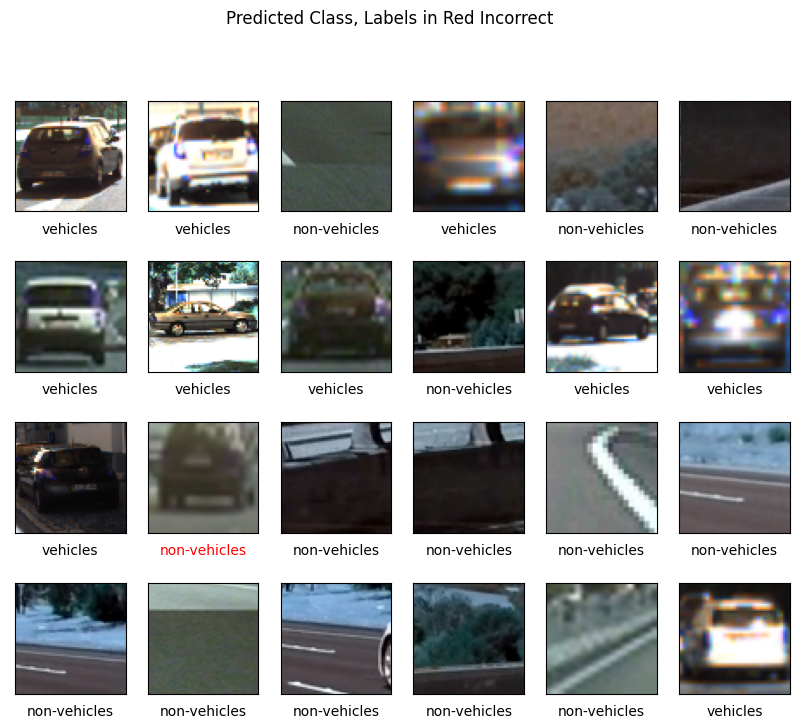

In [85]:
y_fit_ = model.predict(X_test)
yf=[int(i) for i in y_fit_]
plot_predictions(X_test, y_test, yf, 4, 6)

### Compile and Fit Data to Model

In [136]:
# compiling model with adam optimizer and binary crossentropy loss function
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.compile(
#     loss='binary_crossentropy', 
#     optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
#     metrics=['accuracy'])

# fitting train_generator to model

model.fit(t_gen, epochs=10, steps_per_epoch=np.ceil(17246/256), verbose=1)

Epoch 1/10


2022-11-04 18:44:18.109840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - 6s 83ms/step - loss: 0.0201 - accuracy: 0.9939
Epoch 2/10
68/68 [==============================] - 6s 80ms/step - loss: 0.0014 - accuracy: 0.9998
Epoch 3/10
68/68 [==============================] - 5s 77ms/step - loss: 7.0624e-04 - accuracy: 1.0000
Epoch 4/10
68/68 [==============================] - 5s 77ms/step - loss: 5.0436e-04 - accuracy: 1.0000
Epoch 5/10
68/68 [==============================] - 5s 78ms/step - loss: 3.8059e-04 - accuracy: 1.0000
Epoch 6/10
68/68 [==============================] - 5s 78ms/step - loss: 2.9104e-04 - accuracy: 1.0000
Epoch 7/10
68/68 [==============================] - 5s 79ms/step - loss: 2.3208e-04 - accuracy: 1.0000
Epoch 8/10
68/68 [==============================] - 5s 79ms/step - loss: 1.8856e-04 - accuracy: 1.0000
Epoch 9/10
68/68 [==============================] - 5s 76ms/step - loss: 1.5965e-04 - accuracy: 1.0000
Epoch 10/10
68/68 [==============================] - 5s 79ms/step - loss: 1.4483e-04 - accur

In [191]:
# model.evaluate(t_gen)
model.history

In [188]:
model.predict(resize(cv2.imread('my_car.png'), (64,64,3)))

ValueError: in user code:

    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:230 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (32, 64, 3)


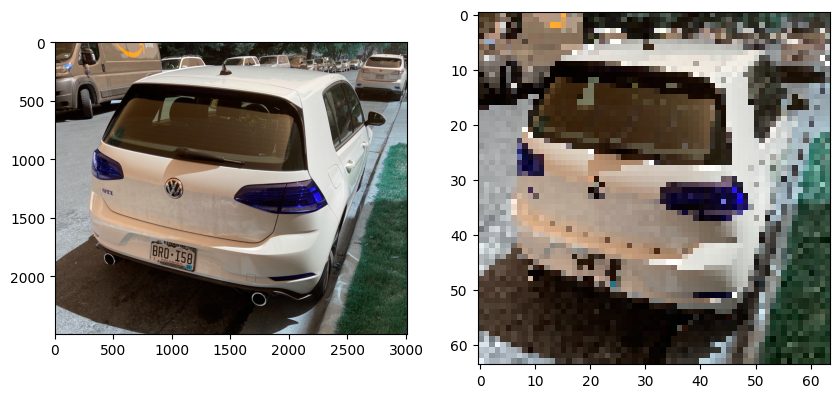

In [59]:
my_car = cv2.resize(cv2.imread('my_car.png'), (64, 64))

f, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].imshow(cv2.imread('my_car.png'))
ax[1].imshow(my_car)

# model.predict(my_car)

In [60]:
my_car.shape

(64, 64, 3)

In [153]:
nsamples, nx, ny = my_car.shape

model.predict(my_car.reshape(nsamples, nx*ny))

ValueError: in user code:

    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/homebrew/anaconda3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:230 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 450)


In [195]:
## fit standard


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(64, 64, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

# model.build(input_shape=(64,64,3))
model.summary()

# compiling model with adam optimizer and binary crossentropy loss function
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.compile(
#     loss='binary_crossentropy', 
#     optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
#     metrics=['accuracy'])

# fitting train_generator to model

model.fit(X_train, y_train, epochs=10, steps_per_epoch=np.ceil(17760/256), verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                7872576   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 7,875,585
Trainable params: 7,875,585
Non-trainable params: 0
_________________________________________________________________


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [194]:
t_gen.samples

17760